<a href="https://colab.research.google.com/github/Vietanh239/CIFAR10/blob/main/Simple_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Thư viện

In [ ]:
import numpy as np
import torch 
import torch.nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
#--------------------------------Thư viện cần thiết cho vẽ ------------------
from __future__ import division, print_function, unicode_literals
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(5)
from torchvision import transforms


In [ ]:
from __future__ import division

import os, sys, pdb, shutil, time, random, datetime
import argparse
import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
!pip install tensorboardX
from tensorboardX import SummaryWriter

In [ ]:
!git clone https://github.com/waleedka/hiddenlayer.git

fatal: destination path 'hiddenlayer' already exists and is not an empty directory.


In [ ]:
import hiddenlayer.hiddenlayer as hl


**Hằng số mặc định**

In [ ]:
MODELNAME = "cifar.model"
EPOCH = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data

**train và test**

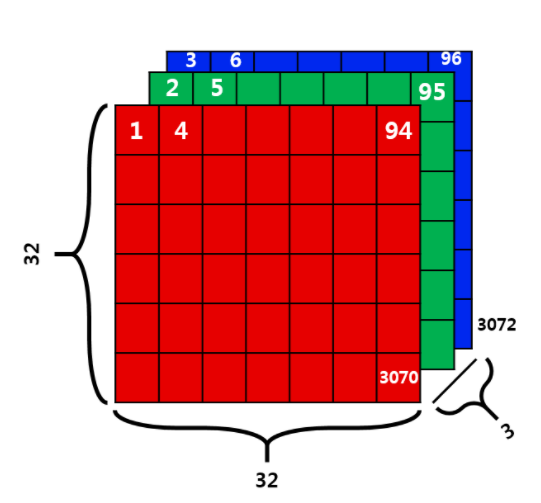

In [ ]:
writer = SummaryWriter()

In [ ]:
class Loader_Data():
  def __init__(self):
    mean = [x / 255 for x in [125.3, 123.0, 113.9]]
    std = [x / 255 for x in [63.0, 62.1, 66.7]]
    train_transform = transforms.Compose([ transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Normalize(mean, std)])
    test_transform = transforms.Compose([transforms.CenterCrop(32), transforms.ToTensor(), transforms.Normalize(mean, std)])
    # load the dataset
    train_dataset = CIFAR10(root='./', train=True, download=True, transform=train_transform)

    self.train_dataset=train_dataset
    self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

    self.test_dataset = CIFAR10(root='./', train=False,transform=test_transform,download = True)
    self.test_loader = DataLoader(dataset=self.test_dataset, batch_size=100, shuffle=False) #Test
    print("Bộ CIFAR có : {} dữ liệu Train, {} dữ liệu test".format(len(train_dataset),len(self.test_dataset)))

    self.classes=['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
  def Show_img(self):
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      img = images[idx].copy() / 2 + 0.5  
      plt.imshow(np.transpose(img, (1, 2, 0)))  
      ax.set_title(self.classes[labels[idx]])    
  def Show_Graph_Train(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()
    for i,j in self.train_dataset:
      num_each_class[self.classes[j]]+=1

    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Train Plotting')
    plt.show()
  def Show_Graph_Test(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    for i,j in self.test_dataset:
      num_each_class[self.classes[j]]+=1
    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Test Plotting')
    plt.show()
  def Show_Graph(self):
    self.Show_Graph_Train()
    self.Show_Graph_Test()


# Model

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class simplenet(nn.Module):
    def __init__(self, classes=10, simpnet_name='simplenet'):
        super(simplenet, self).__init__()
        #print(simpnet_name)
        self.features = self._make_layers() #self._make_layers(cfg[simpnet_name])
        self.classifier = nn.Linear(256, classes)
        self.drp = nn.Dropout(0.1)

    def load_my_state_dict(self, state_dict):

        own_state = self.state_dict()

        # print(own_state.keys())
        # for name, val in own_state:
        # print(name)
        for name, param in state_dict.items():
            name = name.replace('module.', '')
            if name not in own_state:
                # print(name)
                continue
            if isinstance(param, Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print("STATE_DICT: {}".format(name))
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                      ' {} and whose dimensions in the checkpoint are {}, ... Using Initial Params'.format(
                    name, own_state[name].size(), param.size()))

    def forward(self, x):
        # print(x.shape)
        out = self.features(x)
        # print(out.shape)  
        #Global Max Pooling
        out = F.max_pool2d(out, kernel_size=out.size()[2:]) 

        # out = F.dropout2d(out, 0.1, training=True)
        out = self.drp(out)

        out = out.view(out.size(0), -1)
 
        out = self.classifier(out)
        return out

    def _make_layers(self):

        model = nn.Sequential(
            #Layer 1
                             nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),
            #Layer 2
                             nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),
            #Layer 3
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),
            #Layer 4
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),

            #Layer 5
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),
            #Layer 6
                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),
            #Layer 7
                             nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),
            #Layer 8

                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

            #Layer 9
                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),

            #Layer 10

                             nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),
            #Layer 11

                             nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

            #Layer 12

                             nn.Conv2d(2048, 256, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),
            #Layer 13

                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                            )

        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

        return model

In [ ]:
from torchsummary import summary
model = simplenet().to(DEVICE)
for child in model.named_modules():
  print(child)

('', simplenet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (13): Dropout2d(p=0.1, inplace=False)
    (14): Conv2d(128, 128, kernel_s

In [ ]:
print(model)

## Xây dựng CheckPoint

## Xây dựng quá trình Train và test

In [ ]:
import torch.nn as nn
cifar_canvas = hl.Canvas()
cifar_history = hl.History()
class TRAIN_MODEL:
  def __init__(self,data_loader,EPOCH=10,patience=3):
    self.data_loader=data_loader
    self.model = simplenet().to(DEVICE)


    ##Batch loss
    self.batch_train_loss=[]
    self.EPOCH=EPOCH
    

  def train(self):

    optimizer = torch.optim.Adam(self.model.parameters())
    for epoch in range(self.EPOCH):
        # để theo dõi TrainLoss khi mô hình đào tạo
        train_losses = []


        ###################
        # train the model #
        ###################
        sum_train_loss=0.0
        for images, label in self.data_loader.train_loader:
          images, label = images.to(DEVICE), label.to(DEVICE)
          optimizer.zero_grad()
          output = self.model(images)
          batchloss = F.cross_entropy(output,label)
          batchloss.backward()
          sum_train_loss+= batchloss.item()
          optimizer.step()
          pred_labels = np.argmax(output.detach().cpu().numpy(), 1)
          accuracy = np.mean(pred_labels == label.detach().cpu().numpy())
          cifar_history.log(epoch,
                              loss=1-accuracy, accuracy=accuracy)
       

        
        #Add Loss
        self.batch_train_loss.append(sum_train_loss)
        print_msg = ('[{}/{}]'.format(epoch+1,self.EPOCH) + f'train loss: {sum_train_loss:.5f} ')
        
        print(print_msg)
    
    torch.save(self.model.state_dict(), MODELNAME)




Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Bộ CIFAR có : 50000 dữ liệu Train, 10000 dữ liệu test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

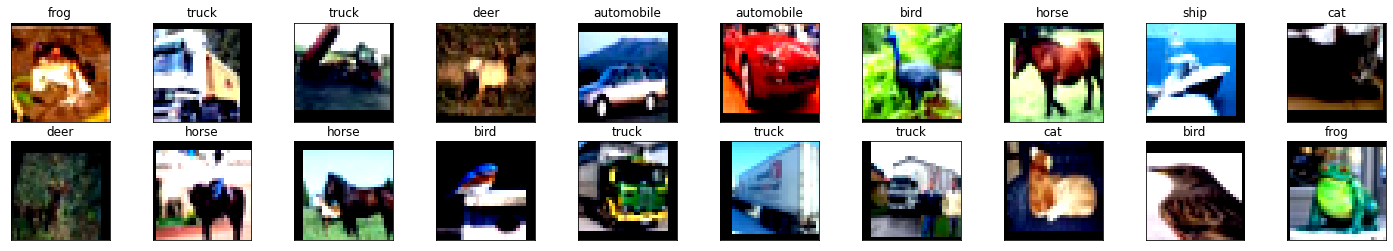

In [ ]:
Data=Loader_Data()
Data.Show_img()


In [ ]:
a=Data.train_dataset[0]
type(a[0])

torch.Tensor

Class airplane have 5000 objects
Class automobile have 5000 objects
Class bird have 5000 objects
Class cat have 5000 objects
Class deer have 5000 objects
Class dog have 5000 objects
Class frog have 5000 objects
Class horse have 5000 objects
Class ship have 5000 objects
Class truck have 5000 objects


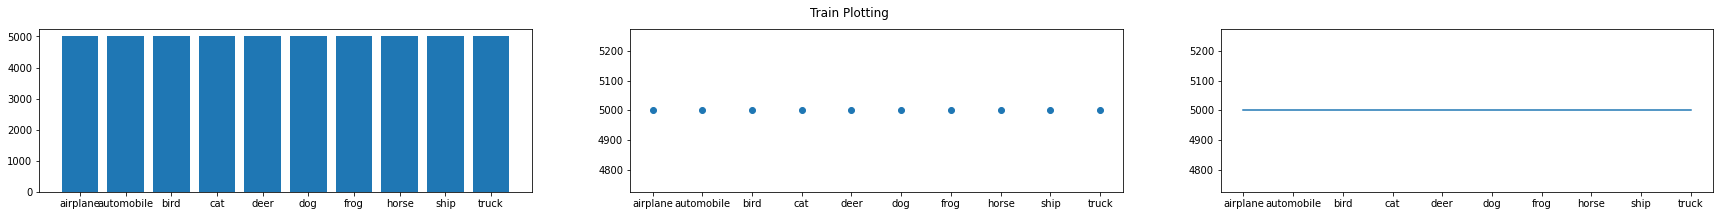

Class airplane have 1000 objects
Class automobile have 1000 objects
Class bird have 1000 objects
Class cat have 1000 objects
Class deer have 1000 objects
Class dog have 1000 objects
Class frog have 1000 objects
Class horse have 1000 objects
Class ship have 1000 objects
Class truck have 1000 objects


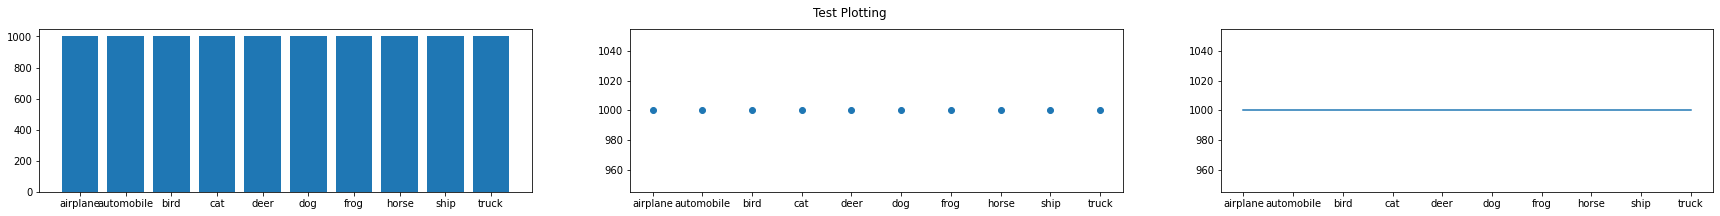

In [ ]:
Data.Show_Graph()

In [ ]:
MyModel=TRAIN_MODEL(Data,30)
MyModel.train()

[1/30]train loss: 707.60434 
[2/30]train loss: 474.70099 
[3/30]train loss: 379.18403 
[4/30]train loss: 322.50944 
[5/30]train loss: 282.95141 
[6/30]train loss: 255.02271 
[7/30]train loss: 231.51925 
[8/30]train loss: 213.42038 
[9/30]train loss: 197.26301 
[10/30]train loss: 184.98043 
[11/30]train loss: 168.32281 
[12/30]train loss: 158.25116 
[13/30]train loss: 149.03040 
[14/30]train loss: 140.23408 
[15/30]train loss: 131.98765 
[16/30]train loss: 121.11083 
[17/30]train loss: 117.92659 
[18/30]train loss: 110.37378 
[19/30]train loss: 103.82197 
[20/30]train loss: 96.69150 
[21/30]train loss: 92.83767 
[22/30]train loss: 87.10341 
[23/30]train loss: 82.31222 
[24/30]train loss: 81.07231 
[25/30]train loss: 75.22847 
[26/30]train loss: 71.75158 
[27/30]train loss: 70.72185 
[28/30]train loss: 65.07571 
[29/30]train loss: 61.80605 
[30/30]train loss: 61.23067 


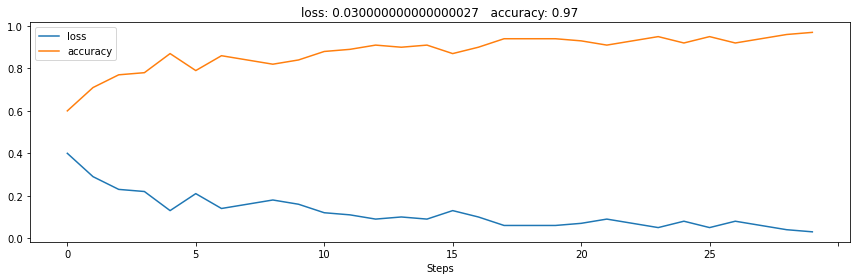

In [ ]:
cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])

## Visual The loss 

## Test

In [ ]:
  test_error=[]
  
  def test(Data):
    test_canvas= hl.Canvas()
    test_history = hl.History()
    correct = 0
    total = float(len(Data.test_loader.dataset))
    model =  simplenet().to(DEVICE)
    model.load_state_dict(torch.load(MODELNAME))
    model.eval()
    i=0
    for images, labels in Data.test_loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      y = model(images).to(DEVICE)
      pred_labels = y.max(dim=1)[1]
      correct = correct + (pred_labels == labels).sum()
      test_history.log(i,loss=1-correct/total, accuracy=correct/total)
      if i%10==0:
        test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
      i+=1

    print("correct: ", correct.item())
    print("total: ", total)
    print("accuracy: ", correct.item()/total)          


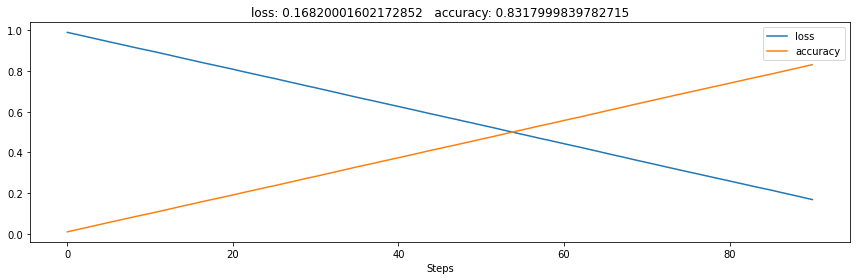

correct:  9145
total:  10000.0
accuracy:  0.9145


In [ ]:
test(Data)

In [ ]:
writer.close()